<a href="https://colab.research.google.com/github/letrongminh/Torch4GANs/blob/main/GANs01_zebra2horse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
import torch
import torch.nn as nn

In [2]:
class ResNetBlock(nn.Module):
  def __init__(self, dim):
    super(ResNetBlock, self).__init__()
    self.conv_block = self.build_conv_block(dim)

  def build_conv_block(self, dim):
    conv_block = [] # khoi tao conv_block
    conv_block += [nn.ReflectionPad2d(1)]
    conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                   nn.InstanceNorm2d(dim),
                   nn.ReLU(True)]

    conv_block += [nn.ReflectionPad2d(1)]
    conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                   nn.InstanceNorm2d(dim)]

    return nn.Sequential(*conv_block)

  def forward(self, x):
    out = x + self.conv_block(x)
    return out

class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9):
      assert(n_blocks >= 0)
      super(ResNetGenerator, self).__init__()

      self.input_nc = input_nc
      self.output_nc = output_nc
      self.ngf = ngf

      model = [nn.ReflectionPad2d(3),
                nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                nn.InstanceNorm2d(ngf),
                nn.ReLU(True)]

      n_downsampling = 2
      
      for i in range(n_downsampling):
        mult = 2**i
        model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                            stride=2, padding=1, bias=True),
                  nn.InstanceNorm2d(ngf * mult * 2),
                  nn.ReLU(True)]
                  
      mult = 2**n_downsampling
      
      for i in range(n_blocks):
        model += [ResNetBlock(ngf * mult)]

      for i in range(n_downsampling):
        mult = 2**(n_downsampling - i)
        model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                      kernel_size=3, stride=2,
                                      padding=1, output_padding=1,
                                      bias=True),
                  nn.InstanceNorm2d(int(ngf * mult / 2)),
                  nn.ReLU(True)]

      model += [nn.ReflectionPad2d(3)]
      model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
      model += [nn.Tanh()]

      self.model = nn.Sequential(*model)

    def forward(self, input):
      return self.model(input)



In [3]:
netG = ResNetGenerator()

In [9]:
!pip install torchviz
from torchviz import make_dot


In [4]:
netG

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [14]:
# load pretrained model

model_path = '/content/drive/MyDrive/Colab_Notebooks_1/CV/GANs/zebra2horse/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)

# load into ResNetGenerator
netG.load_state_dict(model_data)

<All keys matched successfully>

In [15]:
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [16]:
from PIL import Image
from torchvision import transforms

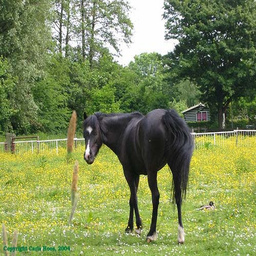

In [17]:
pre_precess = transforms.Compose([transforms.Resize(265),
                                 transforms.ToTensor()])
img = Image.open('/content/drive/MyDrive/Colab_Notebooks_1/CV/GANs/zebra2horse/horse2zebra/testA/n02381460_1030.jpg')
img

In [18]:
img_converted = pre_precess(img)
batch_t = torch.unsqueeze(img_converted, 0)

In [19]:
batch_out = netG(batch_t)


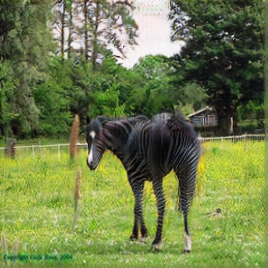

In [20]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
# out_img.save('../data/p1ch2/zebra.jpg')
out_img